In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
# from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random

plt.style.use('fivethirtyeight')

In [2]:
!cat ~/user_state

# ex.
# Now in use: ccc
# Start time: 03/31 12:00
# Estimated end time(option): 03/31 18:00

Now in use:  
Start time:  
Estimated end time(option):   

Next one who want to use:  
Estimated start time: 
Estimated end time(option): 



In [3]:
!nvidia-smi

Sat Oct 28 22:10:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
| 32%   55C    P2             141W / 480W |   6713MiB / 24564MiB |     99%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 10
valid_ratio = 0.2
task = 'forecast'

In [5]:
# Setup seed
random.seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "/home/wmnlab/Documents/sheng-ru/bai/model"

# Define DataSet
dirname = "/home/wmnlab/Documents/sheng-ru/data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dates = ['03-26', '04-01']
test_dates = ['04-10']

def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

def ts_array_create(dirname, dir_list, time_seq):
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0,np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0); df.replace('-',0)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:];
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:];
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]

    if task == 'classification':
        return X_final, HO(Y_final), split_time # classification
    elif task == 'forecast':
        return X_final, reamin_HO_time(Y_final), split_time # forecast HO
#         return X_final, np.sum(Y_final, axis=1), split_time # forecase loss

print('Loading training data...')
X_train, y_train, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

print('Loading testing data...')
X_test, y_test, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

train_data = xgb.DMatrix(X_train_2d, label=y_train)
test_data = xgb.DMatrix(X_test_2d, label=y_test)

GPU 0: NVIDIA GeForce RTX 4090
Loading training data...


  0%|          | 0/320 [00:00<?, ?it/s]

ParserError: Error tokenizing data. C error: Expected 30 fields in line 36, saw 49


In [6]:
X_train.shape, X_train_2d.shape

((38751, 20, 16), (38751, 320))

In [7]:
# train_dir_list, test_dir_list

In [8]:
# Parameters
if task == 'forecast':
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'max_depth': 20, 'eval_metric': ['rmse', 'mae'], 'seed': seed}
elif task == 'classification':
    params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'max_depth': 20, 'eta': 0.1,
              'seed': seed,'eval_metric': ['error','logloss','aucpr']}
n = 600

In [9]:
evals_result = {}
model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    evals=[(train_data, 'train'), (test_data, 'valid')],
    evals_result=evals_result,
    early_stopping_rounds=5,
    verbose_eval=False
)


In [10]:
# # plot evaluation metrics
# epochs = len(evals_result['train']['error'])
# x_axis = range(0, epochs)

# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['error'], label='Train')
# ax.plot(x_axis, evals_result['valid']['error'], label='valid')
# ax.legend()
# plt.ylabel('Error')
# plt.title('XGBoost Error')

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['logloss'], label='Train')
# ax.plot(x_axis, evals_result['valid']['logloss'], label='valid')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['aucpr'], label='Train')
# ax.plot(x_axis, evals_result['valid']['aucpr'], label='valid')
# ax.legend()
# plt.ylabel('aucpr')
# plt.title('XGBoost aucpr')

# plt.show()

In [11]:
preds = model.predict(test_data)

In [12]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test)))
    print(f'RMSE is {rmse}. MAE is {mae}')
elif task == 'classification':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
    
    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

RMSE is 2.82. MAE is 2.033726665369372


In [13]:
# 将模型预测错误的样本保存到一个列表中
errors = []
trues = []
for i in range(len(y_test)):
    if preds[i] > 0.5 and y_test[i] == 0:
        errors.append(X_test[i])
        trues.append(0)
    elif preds[i] <= 0.5 and y_test[i] == 1:
        errors.append(X_test[i])
        trues.append(1)
# # 保存到文件中
# with open("error_samples.txt", "w") as f:
#     for sample in errors:
#         f.write(str(sample) + "\n")


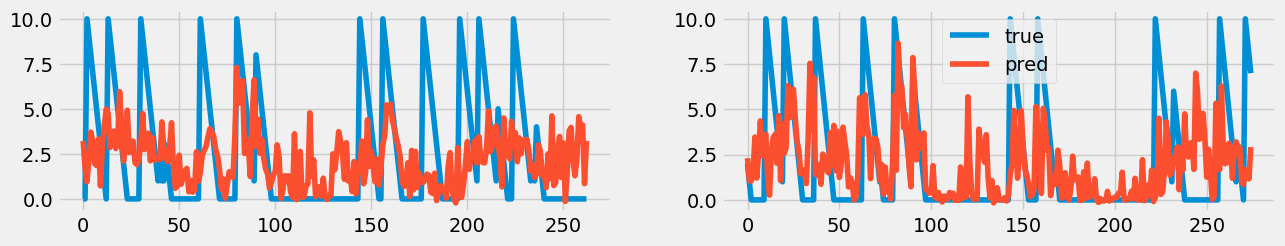

In [14]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[8], split_time_test[9]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

In [15]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-04-17_qc02_exp2_#01_B1B7.csv', '2023-04-01_qc03_exp1_#05_B8.csv']

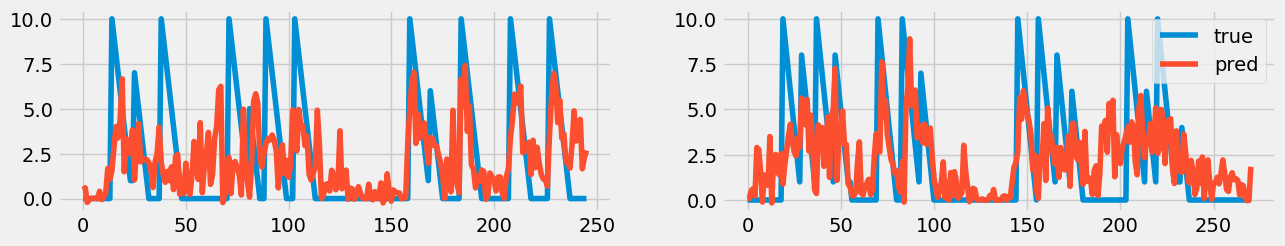

In [16]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[0], split_time_test[1]]
fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

In [17]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-04-01_qc00_exp2_#04_B1B3.csv', '2023-04-17_qc02_exp4_#03_All.csv']

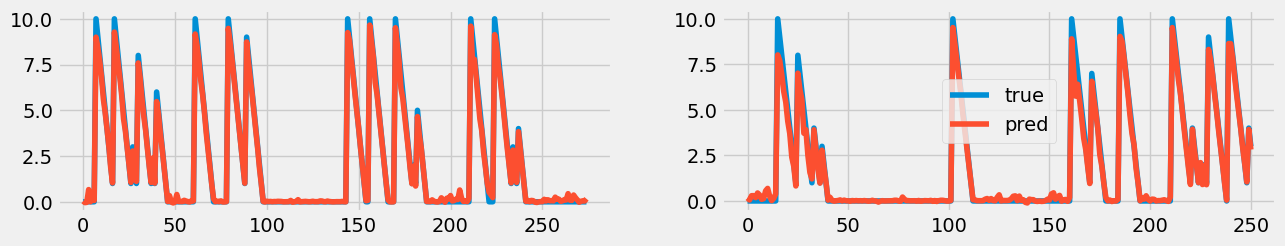

In [18]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(train_data)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

# grid search

## Search on task

In [19]:
def run():
    # Parameters
    if task == 'forecast':
        params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'max_depth': 20, 'eval_metric': ['rmse', 'mae'], 'seed': seed}
    elif task == 'classification':
        params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
                  'subsample': subsample, 'colsample_bytree': colsample_bytree,
                  'alpha': reg_alpha,'gamma': gamma,  
                  'seed': seed,'eval_metric': ['error','logloss']}

    model = xgb.train(
        params=params,
        dtrain=train_data,
        num_boost_round=n_esti,
        evals=[(train_data, 'train'), (test_data, 'valid')],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    preds = model.predict(test_data)

    # plot all data point on a plot
    ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

    if task == 'forecast':
        rmse = round(np.sqrt(np.mean((preds-y_test)**2)), 2)
        plt.title(f'RMSE is {rmse}.')
    elif task == 'classification':
        # PR and AUCPR
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        aucpr = auc(recall, precision)
        
        # ROC & AUC
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        roc_auc = auc(fpr, tpr)
        
        threshold = 0.5
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
        
        print('PR Curve (AUCPR = %0.2f)' % aucpr)
        print(f'ROC Auc is {roc_auc}.')
        print('============================================================')
        cols_out = [time_seq, predict_t, lr, max_d, n_esti, subsample, colsample_bytree, reg_alpha, gamma, roc_auc, aucpr, p, r, f1]
        cols_out = [str(n) for n in cols_out]
        f_out.write(','.join(cols_out)+'\n')
        
# Time sequence length and prediction time length
seed = 55688
time_seqs = [20]
predict_ts = list(range(1,20+1,2))
lrs = [0.3, 0.1]
max_ds = [7, 15]
n_estis = [200]
subsamples = [1]
colsample_bytrees = [0.9]
reg_alphas = [0.5]
gammas = [0.1]
valid_ratio = 0.2
task = 'classification'

dirname = "/home/wmnlab/Documents/sheng-ru/data/single"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]


features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
            'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC']
# target = ['RLF']

num_of_features = len(features)

out = 'result_tpreds_lte_HO.csv'
f_out = open(out, mode='w')
cols_out = ['t_seq','t_pred','lr','max_dep','n_esti','subsample','colsample_bytree','reg_alpha','gamma','auc','aucpr','p','r','f1']
f_out.write(','.join(cols_out)+'\n')

train_pos = []
train_neg = []

for time_seq in time_seqs:
    for predict_t in predict_ts:
        print(f'predict_t {predict_t}')
        X_train, y_train, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
        X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

        X_test, y_test, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
        X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

        train_data = xgb.DMatrix(X_train_2d, label=y_train)
        test_data = xgb.DMatrix(X_test_2d, label=y_test)
        
        train_neg.append(y_train.count(0)); train_pos.append(y_train.count(1))
        print('train 0:',y_train.count(0), 'train 1:', y_train.count(1))
        
        for lr in lrs:
            for max_d in max_ds:
                for n_esti in n_estis:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            for reg_alpha in reg_alphas:
                                for gamma in gammas:
                                    run()

f_out.close()

predict_t 1


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 37811 train 1: 2385
th: 0.5; Acc: 94.75384416591291; precision: 0.68; recall:0.21; f1:0.32
PR Curve (AUCPR = 0.42)
ROC Auc is 0.8950636352217662.
th: 0.5; Acc: 94.67631476935004; precision: 0.73; recall:0.16; f1:0.26
PR Curve (AUCPR = 0.45)
ROC Auc is 0.9031673074160861.
th: 0.5; Acc: 94.84429512856958; precision: 0.75; recall:0.19; f1:0.3
PR Curve (AUCPR = 0.48)
ROC Auc is 0.9118175748240469.
th: 0.5; Acc: 94.59878537278719; precision: 0.72; recall:0.14; f1:0.23
PR Curve (AUCPR = 0.45)
ROC Auc is 0.9058654263953502.
predict_t 3


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 33320 train 1: 6580
th: 0.5; Acc: 87.69691446426246; precision: 0.72; recall:0.42; f1:0.53
PR Curve (AUCPR = 0.66)
ROC Auc is 0.8948882440674217.
th: 0.5; Acc: 87.51464653039969; precision: 0.72; recall:0.4; f1:0.51
PR Curve (AUCPR = 0.64)
ROC Auc is 0.894408783946431.
th: 0.5; Acc: 88.02239291758886; precision: 0.75; recall:0.41; f1:0.53
PR Curve (AUCPR = 0.67)
ROC Auc is 0.9033702688803471.
th: 0.5; Acc: 87.5667230829319; precision: 0.76; recall:0.35; f1:0.48
PR Curve (AUCPR = 0.66)
ROC Auc is 0.8992510349005985.
predict_t 5


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 29550 train 1: 10054
th: 0.5; Acc: 83.82526564344747; precision: 0.74; recall:0.56; f1:0.64
PR Curve (AUCPR = 0.74)
ROC Auc is 0.8821844341619072.
th: 0.5; Acc: 83.58913813459267; precision: 0.76; recall:0.51; f1:0.61
PR Curve (AUCPR = 0.73)
ROC Auc is 0.8812331429775471.
th: 0.5; Acc: 84.3631116358389; precision: 0.78; recall:0.53; f1:0.63
PR Curve (AUCPR = 0.76)
ROC Auc is 0.892664595689358.
th: 0.5; Acc: 84.83536665354848; precision: 0.8; recall:0.53; f1:0.64
PR Curve (AUCPR = 0.77)
ROC Auc is 0.899122117913283.
predict_t 7


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 26318 train 1: 12990
th: 0.5; Acc: 81.78453403833443; precision: 0.77; recall:0.65; f1:0.7
PR Curve (AUCPR = 0.80)
ROC Auc is 0.882673749690173.
th: 0.5; Acc: 81.7713152676801; precision: 0.77; recall:0.64; f1:0.7
PR Curve (AUCPR = 0.80)
ROC Auc is 0.8835121398419756.
th: 0.5; Acc: 81.6787838730998; precision: 0.78; recall:0.62; f1:0.69
PR Curve (AUCPR = 0.80)
ROC Auc is 0.8847438995705418.
th: 0.5; Acc: 83.00066093853272; precision: 0.8; recall:0.65; f1:0.72
PR Curve (AUCPR = 0.82)
ROC Auc is 0.8963942623842259.
predict_t 9


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 23496 train 1: 15516
th: 0.5; Acc: 79.01958172372451; precision: 0.76; recall:0.7; f1:0.73
PR Curve (AUCPR = 0.81)
ROC Auc is 0.8662654692850075.
th: 0.5; Acc: 80.96443319568402; precision: 0.78; recall:0.73; f1:0.75
PR Curve (AUCPR = 0.84)
ROC Auc is 0.8853088149269321.
th: 0.5; Acc: 80.60476888237645; precision: 0.79; recall:0.7; f1:0.74
PR Curve (AUCPR = 0.83)
ROC Auc is 0.8793603524953435.
th: 0.5; Acc: 81.59051551884907; precision: 0.79; recall:0.73; f1:0.76
PR Curve (AUCPR = 0.86)
ROC Auc is 0.8936594784729776.
predict_t 11


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 21022 train 1: 17694
th: 0.5; Acc: 78.31923748154115; precision: 0.76; recall:0.77; f1:0.76
PR Curve (AUCPR = 0.85)
ROC Auc is 0.8655156577719185.
th: 0.5; Acc: 79.24553631359915; precision: 0.78; recall:0.77; f1:0.77
PR Curve (AUCPR = 0.86)
ROC Auc is 0.8779600471796072.
th: 0.5; Acc: 79.9973150758491; precision: 0.79; recall:0.78; f1:0.78
PR Curve (AUCPR = 0.86)
ROC Auc is 0.877500909724729.
th: 0.5; Acc: 81.28607866827761; precision: 0.8; recall:0.8; f1:0.8
PR Curve (AUCPR = 0.88)
ROC Auc is 0.8928968142461662.
predict_t 13


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 18835 train 1: 19585
th: 0.5; Acc: 78.97442835881478; precision: 0.79; recall:0.81; f1:0.8
PR Curve (AUCPR = 0.87)
ROC Auc is 0.8695430076803595.
th: 0.5; Acc: 79.36679745636584; precision: 0.78; recall:0.84; f1:0.81
PR Curve (AUCPR = 0.87)
ROC Auc is 0.8718438217846738.
th: 0.5; Acc: 79.25855770531727; precision: 0.79; recall:0.82; f1:0.8
PR Curve (AUCPR = 0.88)
ROC Auc is 0.8736427254455977.
th: 0.5; Acc: 80.340955215803; precision: 0.79; recall:0.84; f1:0.81
PR Curve (AUCPR = 0.89)
ROC Auc is 0.8827615109661049.
predict_t 15


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 16908 train 1: 21216
th: 0.5; Acc: 79.87181235510705; precision: 0.8; recall:0.86; f1:0.83
PR Curve (AUCPR = 0.89)
ROC Auc is 0.875134431352719.
th: 0.5; Acc: 80.10364107459431; precision: 0.8; recall:0.87; f1:0.83
PR Curve (AUCPR = 0.89)
ROC Auc is 0.8760675118127895.
th: 0.5; Acc: 80.48547661257331; precision: 0.8; recall:0.87; f1:0.83
PR Curve (AUCPR = 0.90)
ROC Auc is 0.8777958606539068.
th: 0.5; Acc: 81.07186690304104; precision: 0.81; recall:0.88; f1:0.84
PR Curve (AUCPR = 0.91)
ROC Auc is 0.8893909541792311.
predict_t 17


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 15199 train 1: 22629
th: 0.5; Acc: 80.98969072164948; precision: 0.82; recall:0.88; f1:0.85
PR Curve (AUCPR = 0.91)
ROC Auc is 0.881689043550938.
th: 0.5; Acc: 81.64948453608247; precision: 0.82; recall:0.91; f1:0.86
PR Curve (AUCPR = 0.92)
ROC Auc is 0.8869929138490888.
th: 0.5; Acc: 81.22336769759451; precision: 0.81; recall:0.9; f1:0.85
PR Curve (AUCPR = 0.91)
ROC Auc is 0.8841450907729879.
th: 0.5; Acc: 82.55670103092784; precision: 0.82; recall:0.92; f1:0.87
PR Curve (AUCPR = 0.92)
ROC Auc is 0.895737941969889.
predict_t 19


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

train 0: 13713 train 1: 23819
th: 0.5; Acc: 81.64057087432451; precision: 0.83; recall:0.9; f1:0.86
PR Curve (AUCPR = 0.92)
ROC Auc is 0.8731095235890033.
th: 0.5; Acc: 82.54122211445198; precision: 0.83; recall:0.92; f1:0.87
PR Curve (AUCPR = 0.93)
ROC Auc is 0.8840098565920644.
th: 0.5; Acc: 82.22253013717611; precision: 0.83; recall:0.92; f1:0.87
PR Curve (AUCPR = 0.92)
ROC Auc is 0.8832200960078819.
th: 0.5; Acc: 82.99847582097824; precision: 0.83; recall:0.93; f1:0.88
PR Curve (AUCPR = 0.93)
ROC Auc is 0.896330087779071.


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

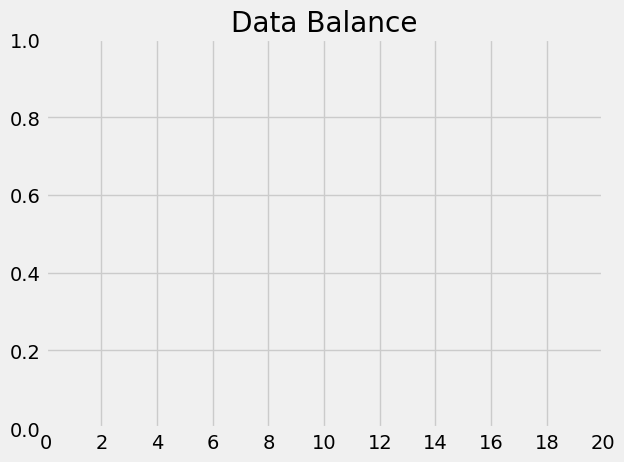

In [20]:
train_pos, train_neg
y = []
x = list(range(1,20+1))
for p, n in zip(train_pos, train_neg):
    y.append(p/(p+n))

ax = plt.gca()
x_ticks = range(0,20+1,2)
ax.set_xticks(x_ticks)
plt.title('Data Balance')
plt.plot(x, y, label='Positive Ratio')
plt.xlabel('Prediction Time')
plt.legend()
plt.show()

In [ ]:
# df = pd.read_csv('result_tpreds_SN_setup.csv')
df = pd.read_csv('result_tpreds_SN_setup.csv')
x = df["t_pred"]
y1 = df["auc"]
y2 = df["aucpr"]
plt.plot(x, y1, label='Auc')
plt.plot(x, y2, label='Aucpr')
ax = plt.gca()
x_ticks = np.arange(2,22,2)
ax.set_xticks(x_ticks)
plt.xlabel(r'$\bf Predict\ Time\ (sec)$')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('result_tseqs.csv')
x = df["t_seq"]
y1 = df["auc"]
y2 = df["aucpr"]
plt.plot(x, y1, label='Auc')
plt.plot(x, y2, label='Aucpr')
plt.xlabel(r'$\bf Input\ Length\ (sec)$')
ax = plt.gca()
x_ticks = np.arange(2,22,2)
ax.set_xticks(x_ticks)
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('result_predt.csv')
x = df["t_pred"]
y1 = df["auc"]
y2 = df["aucpr"]
plt.plot(x, y1, label='Auc')
plt.plot(x, y2, label='Aucpr')
ax = plt.gca()
x_ticks = np.arange(2,22,2)
ax.set_xticks(x_ticks)
plt.xlabel(r'$\bf Predict\ Time\ (sec)$')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('result.csv')
max_value = df['aucpr'].max()
max_index = df['aucpr'].idxmax()
df.iloc[max_index]
max_value = df['auc'].max()
max_index = df['auc'].idxmax()
df.iloc[max_index]

In [ ]:
X = 'gamma'
y = [0.,0.1,0.5]
df = pd.read_csv('result.csv')
x = list(range(729))
A = df[df[X]==y[0]]
B = df[df[X]==y[1]]
C = df[df[X]==y[2]]
plt.plot(x,A['aucpr'], label='1')
plt.plot(x,B['aucpr'], label='2')
plt.plot(x,C['aucpr'], label='3')
# plt.plot(df['auc'], label='auc')
plt.legend()
plt.show()

# Stage II. Classification and Forecast

In [42]:
def ts_array_create(dirname, dir_list, time_seq):
    
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]
    
    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO

## Classification

In [43]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 20
lr = 0.1
max_d = 15
n_esti = 200
subsample = 1
colsample_bytree = 0.9
reg_alpha = 0.5
gamma = 0.1
valid_ratio = 0.2

random.seed(seed)

dirname = "/home/wmnlab/Documents/sheng-ru/data/single"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ] # Take out data with sm
# dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not '_B1.' in f and not '_LTE' in f) )] # Take out B1 and LTE not NSA data

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Put sm data in train dir
# train_dir_list = [f for f in train_dir_list if (not '_B1.' in f and not '_LTE' in f)] # Take out sm data of not NSA mode 

features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
            'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1',
            'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# target = ['LTE_HO', 'MN_HO'] # For eNB HO.
target = [ 'gNB_Rel', 'gNB_HO']
# target = ['eNB_to_ENDC'] # For SN setup
# target = ['RLF']

num_of_features = len(features)

# Data
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

train_data = xgb.DMatrix(X_train_2d, label=y_train1)
test_data = xgb.DMatrix(X_test_2d, label=y_test1)


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [44]:
# Parameters
params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
            'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,  
            'seed': seed,'eval_metric': ['error','logloss','aucpr']}

model1 = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n_esti,
    evals=[(train_data, 'train'), (test_data, 'valid')],
    early_stopping_rounds=10,
    verbose_eval=False
)

In [45]:
preds1 = model1.predict(test_data)

# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

# PR and AUCPR
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
aucpr = auc(recall, precision)

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test1, preds1)
roc_auc = auc(fpr, tpr)

# Record Error 
Errors = []


# Manually count
for threshold in ths:
    TP, FP, TN, FN = 0,0,0,0
    anses = np.where(preds1<threshold, 0, 1)
    for ans, y, y2 in zip(anses, y_test1, y_test2):
        if ans == y:
            if ans == 1: TP += 1
            elif ans == 0: TN +=1
        elif ans != y:
            Errors.append(y2)
            if ans == 1: FP += 1
            elif ans == 0: FN +=1
    acc=(TP+TN)/(TP+TN+FP+FN)*100
    try:
        p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
        f1 = round(2*(p*r)/(p+r), 2)
    except:
        p, r, f1 = 'DNF', 'DNF', 'DNF'
    s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
    print(s)
print('PR Curve (AUCPR = %0.2f)' % aucpr)
print(f'ROC Auc is {roc_auc}.')
print('==========================================================================')


th: 0.2; Acc: 84.90617723599507; precision: 0.78; recall:0.98; f1:0.87
th: 0.3; Acc: 86.15258183810437; precision: 0.8; recall:0.96; f1:0.87
th: 0.4; Acc: 86.91960005478701; precision: 0.82; recall:0.94; f1:0.88
th: 0.5; Acc: 87.083961101219; precision: 0.83; recall:0.92; f1:0.87
th: 0.6; Acc: 87.09765785508834; precision: 0.85; recall:0.89; f1:0.87
th: 0.7; Acc: 86.56348445418436; precision: 0.88; recall:0.85; f1:0.86
th: 0.8; Acc: 85.15271880564306; precision: 0.9; recall:0.79; f1:0.84
PR Curve (AUCPR = 0.94)
ROC Auc is 0.9460179327387972.


In [46]:
# save model
save_path = '/home/wmnlab/Documents/sheng-ru/YU/model/'
save_name = 'setup_cls_xgb.json'
f = os.path.join(save_path, save_name)
model1.save_model(f)

In [47]:
# Time sequence length and prediction time length
lr = 0.3
max_d = 7
n_esti = 200
subsample = 1
colsample_bytree = 0.9
reg_alpha = 0.5
gamma = 0.1
task = 'forecast'

cond = y_train2 > 0
X_train_2d_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]
cond = y_test2 > 0
X_test_2d_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]

train_data = xgb.DMatrix(X_train_2d_fore, label=y_train2_fore)
test_data = xgb.DMatrix(X_test_2d_fore, label=y_test2_fore)

In [48]:
# Parameters
if task == 'forecast':
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
              'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,  
              'seed': seed,'eval_metric': ['rmse', 'mae']}
elif task == 'classification':
    params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
                'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,  
                'seed': seed,'eval_metric': ['error','logloss','aucpr']}

model2 = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=600,
    evals=[(train_data, 'train'), (test_data, 'valid')],
    early_stopping_rounds=10,
    # verbose_eval=False
)

[0]	train-rmse:7.53231	train-mae:5.81128	valid-rmse:7.52636	valid-mae:5.76950
[1]	train-rmse:6.05174	train-mae:4.55271	valid-rmse:6.15784	valid-mae:4.61351
[2]	train-rmse:5.07954	train-mae:3.80983	valid-rmse:5.26334	valid-mae:3.93756
[3]	train-rmse:4.50371	train-mae:3.38723	valid-rmse:4.78027	valid-mae:3.59263
[4]	train-rmse:4.12244	train-mae:3.11739	valid-rmse:4.50125	valid-mae:3.40470
[5]	train-rmse:3.83878	train-mae:2.90956	valid-rmse:4.30500	valid-mae:3.26419
[6]	train-rmse:3.66335	train-mae:2.78013	valid-rmse:4.17475	valid-mae:3.17250
[7]	train-rmse:3.51374	train-mae:2.66640	valid-rmse:4.11391	valid-mae:3.13354
[8]	train-rmse:3.38785	train-mae:2.56830	valid-rmse:4.08945	valid-mae:3.11075
[9]	train-rmse:3.32259	train-mae:2.52491	valid-rmse:4.06839	valid-mae:3.10106
[10]	train-rmse:3.27558	train-mae:2.48861	valid-rmse:4.06151	valid-mae:3.09764
[11]	train-rmse:3.20815	train-mae:2.43488	valid-rmse:4.05588	valid-mae:3.08973
[12]	train-rmse:3.15438	train-mae:2.39016	valid-rmse:4.05827	v

In [49]:
preds2 = model2.predict(test_data)

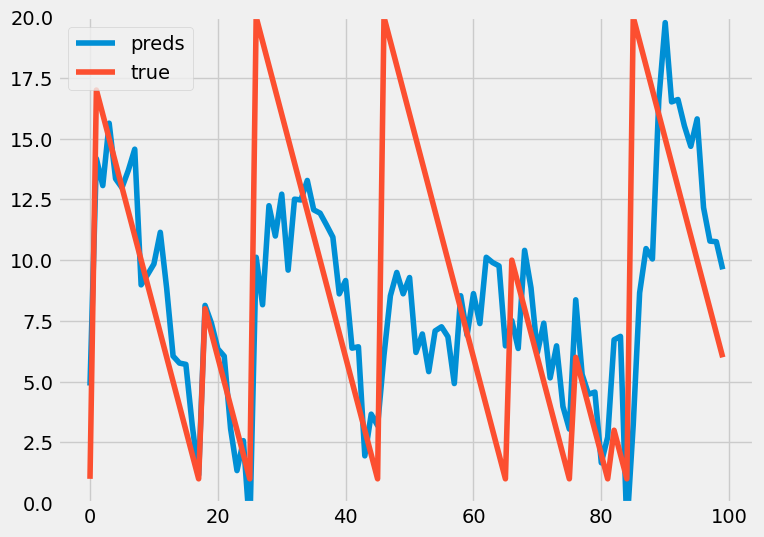

In [50]:
plt.figure(figsize=(8, 6))
x = 400
y = 500
plt.plot(preds2[x:y], label = 'preds')
plt.plot(y_test2_fore[x:y], label = 'true')
plt.ylim([0,predict_t])
plt.legend()
plt.show()

## Visualization

In [51]:
test_data = xgb.DMatrix(X_test_2d)
preds_ho = model1.predict(test_data)
preds_ho_time = model2.predict(test_data)

In [52]:
ans = np.where(preds_ho>0.5, preds_ho_time, 0)

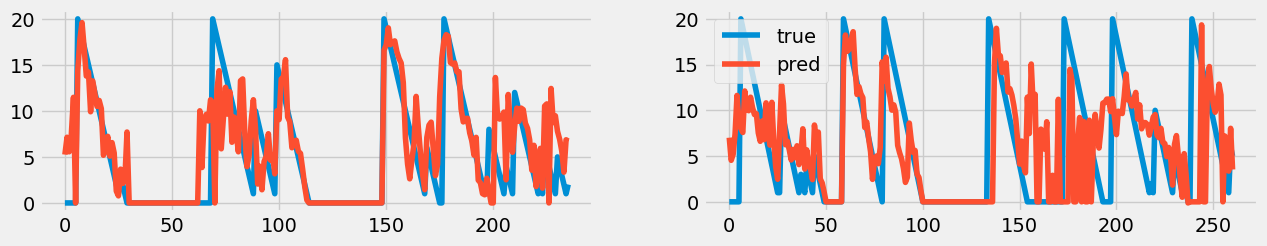

In [53]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[0], split_time_test[1]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    
    true_ho_time = [y_test2[i] for i in range(samples[i][0], samples[i][1])]
        
    axs[i].plot(true_ho_time, label='true')
    prediciton_ho = [ans[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton_ho, label='pred')

plt.legend()
plt.show()

In [41]:
# save model
save_path = '/home/wmnlab/Documents/sheng-ru/YU/model/'
save_name = 'nr_HO_fcst_xgb.json'
f = os.path.join(save_path, save_name)
model2.save_model(f)